In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
_log = logging.getLogger()

In [3]:
from pylab import *

In [4]:
rcParams['figure.figsize'] = 12,9
rcParams['font.size'] = 18
rcParams['axes.grid'] = True

In [5]:
from pytorch_utils.nb_figure import NBFigure

In [6]:
import incense
from utils import get_incense_loader
from pyrsistent import freeze, thaw
import torch
import imageio

In [7]:
from model_ingredient import make_model

In [8]:
loader = get_incense_loader("auth.json")

In [9]:
# 86
ex = loader.find_by_id(86)

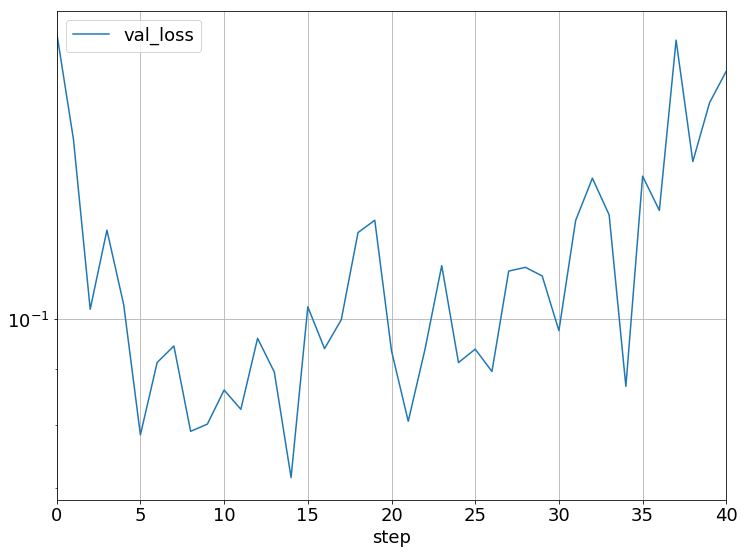

In [10]:
semilogy()
# ex.metrics['train_loss'].plot()
ex.metrics['val_loss'].plot()
legend()

In [11]:
thaw(ex.config)

{'dataset': {'__doc__': 'Config for data source and loading',
  'num_workers': 0,
  'device': 'cpu',
  'val_split': 0.05,
  'batch_size': 32},
 'seed': 389066854,
 '__doc__': 'Config for optimzier\nCurrently available opts (types of optimizers):\n    adam\n    adamax\n    rmsprop\n',
 'epochs': 100,
 'weight_decay': 0,
 'lr': 0.001,
 'model': {'device': 'cpu',
  'channels': [1],
  '__doc__': 'Config for model',
  'denses': [784, 300, 300, 10],
  'input_size': 28,
  'activation': 'relu'},
 'opt': 'adam',
 'save_every': 1}

In [12]:
def stable_rank(s):
    ssq = s**2
    return s.sum()/s.max()

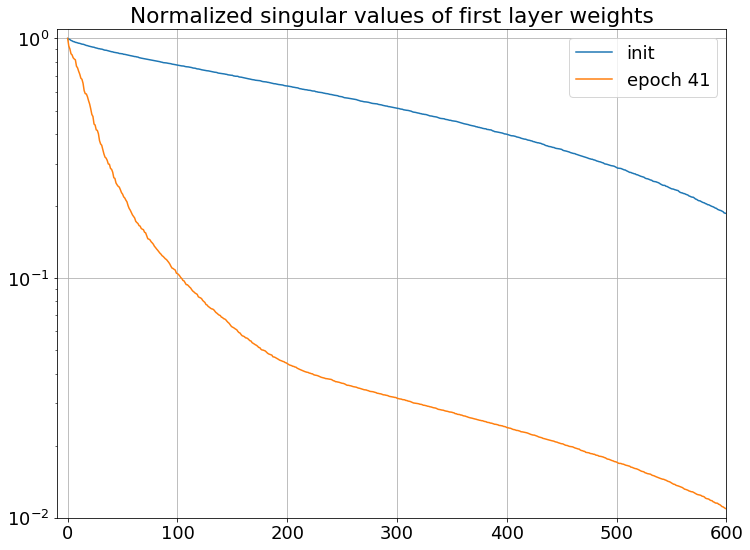

In [13]:
model = make_model(**thaw(ex.config.model), _log=_log)

nbf = NBFigure(image_path='fig.png')

a = nbf.getAxis()
a.set_yscale('log')
a.set_title("Normalized singular values of first layer weights")
s = svd(model.dense[0].weight.data, compute_uv=False)
s = s/s.max()
srs = [stable_rank(s)]
l, = a.plot(s, label='init')
l, = a.plot(s, label='init')
a.legend()
nbf.set_xlim((-10, 600))
nbf.set_ylim((1e-2, 1.1))

nbf.display()
nbf.update()

In [14]:
ims = [imageio.imread('fig.png')]*10
for art in ex.artifacts:
    sd = torch.load(f"runs/{ex.id}/{art}")
    model.load_state_dict(sd)
    s = svd(model.dense[0].weight.data, compute_uv=False)
    s = s/s.max()
    l.set_data(arange(len(s)), s)
    l.set_label(f'epoch {int(art[:3])+1}')
#     a.plot(s, label=f'epoch {int(art[:3])+1}')
    srs.append(stable_rank(s))
    a.legend()
    nbf.update()
    ims.append(imageio.imread('fig.png'))

In [15]:
imageio.mimwrite('svd.gif', ims)

![](svd.gif)

In [16]:
v = array(ex.metrics['val_loss'])
v = v-v.mean()
v = v/v.std()

In [17]:
s = array(srs[1:])
s = s-s.mean()
s = s/s.std()